In [1]:
from hmmlearn import hmm

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.io.wavfile import write
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
from pyAudioAnalysis import audioFeatureExtraction as aF
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import hmmlearn.hmm
from pyAudioAnalysis import audioTrainTest as aT
from scipy import signal
from scipy.io import wavfile
from scipy.io.wavfile import write
from sklearn.cluster import KMeans
from scipy.spatial import distance


C:\Users\Videet\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
from __future__ import print_function
import numpy
import sklearn.cluster
import scipy
import os

from scipy.spatial import distance
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis
import csv
import os.path
import sklearn
import sklearn.cluster
import hmmlearn.hmm
import pickle as cPickle
import glob
from scipy.spatial import distance

In [4]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioTrainTest as aT
def diarization(inputfile, mt_size=2.0,mt_step=0.2,st_win=0.05,lda_dim=35,plot_res=True, n_speakers= 2):

#inputfile = "simi_silence.wav"

    [fs, x] = audioBasicIO.readAudioFile(inputfile)
    x = audioBasicIO.stereo2mono(x)
    duration = len(x) / fs

    [classifier_1, MEAN1, STD1, classNames1, mtWin1, mtStep1, stWin1, stStep1, computeBEAT1] = aT.load_model_knn(os.path.join(os.getcwd(), "knnSpeakerAll"))
    [classifier_2, MEAN2, STD2, classNames2, mtWin2, mtStep2, stWin2, stStep2, computeBEAT2] = aT.load_model_knn(os.path.join(os.getcwd(), "knnSpeakerFemaleMale"))

    [mt_feats, st_feats, _] = aF.mtFeatureExtraction(x, fs, mt_size * fs, mt_step * fs, round(fs * st_win), round(fs*st_win * 0.5))


    MidTermFeatures2 = numpy.zeros((mt_feats.shape[0] + len(classNames1) +len(classNames2), mt_feats.shape[1]))

    for i in range(mt_feats.shape[1]):
        cur_f1 = (mt_feats[:, i] - MEAN1) / STD1
        cur_f2 = (mt_feats[:, i] - MEAN2) / STD2
        [res, P1] = aT.classifierWrapper(classifier_1, "knn", cur_f1)
        [res, P2] = aT.classifierWrapper(classifier_2, "knn", cur_f2)
        MidTermFeatures2[0:mt_feats.shape[0], i] = mt_feats[:, i]
        MidTermFeatures2[mt_feats.shape[0]:mt_feats.shape[0]+len(classNames1), i] = P1 + 0.0001
        MidTermFeatures2[mt_feats.shape[0] + len(classNames1)::, i] = P2 + 0.0001
        
    mt_feats = MidTermFeatures2    # TODO
    iFeaturesSelect = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 41,42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

    mt_feats = mt_feats[iFeaturesSelect, :]
    
    (mt_feats_norm, MEAN, STD) = aT.normalizeFeatures([mt_feats.T])
    mt_feats_norm = mt_feats_norm[0].T
    n_wins = mt_feats.shape[1]

    # remove outliers:
    dist_all = numpy.sum(distance.squareform(distance.pdist(mt_feats_norm.T)), axis=0)
    m_dist_all = numpy.mean(dist_all)
    i_non_outliers = numpy.nonzero(dist_all < 1.2 * m_dist_all)[0]

        # TODO: Combine energy threshold for outlier removal:
    #EnergyMin = numpy.min(mt_feats[1,:])
    #EnergyMean = numpy.mean(mt_feats[1,:])
    #Thres = (1.5*EnergyMin + 0.5*EnergyMean) / 2.0
    #i_non_outliers = numpy.nonzero(mt_feats[1,:] > Thres)[0]
    #print i_non_outliers

    perOutLier = (100.0 * (n_wins - i_non_outliers.shape[0])) / n_wins
    mt_feats_norm_or = mt_feats_norm
    mt_feats_norm = mt_feats_norm[:, i_non_outliers]

    # LDA dimensionality reduction:
    if lda_dim > 0:
        #[mt_feats_to_red, _, _] = aF.mtFeatureExtraction(x, fs, mt_size * fs, st_win * fs, round(fs*st_win), round(fs*st_win));
        # extract mid-term features with minimum step:
        mt_win_ratio = int(round(mt_size / st_win))
        mt_step_ratio = int(round(st_win / st_win))
        mt_feats_to_red = []
        num_of_features = len(st_feats)
        num_of_stats = 2
        #for i in range(num_of_stats * num_of_features + 1):
        for i in range(num_of_stats * num_of_features):
            mt_feats_to_red.append([])

        for i in range(num_of_features):        # for each of the short-term features:
            curPos = 0
            N = len(st_feats[i])
            while (curPos < N):
                N1 = curPos
                N2 = curPos + mt_win_ratio
                if N2 > N:
                    N2 = N
                curStFeatures = st_feats[i][N1:N2]
                mt_feats_to_red[i].append(numpy.mean(curStFeatures))
                mt_feats_to_red[i+num_of_features].append(numpy.std(curStFeatures))
                curPos += mt_step_ratio
        mt_feats_to_red = numpy.array(mt_feats_to_red)
        mt_feats_to_red_2 = numpy.zeros((mt_feats_to_red.shape[0] +
                                        len(classNames1) + len(classNames2),
                                         mt_feats_to_red.shape[1]))
        for i in range(mt_feats_to_red.shape[1]):
            cur_f1 = (mt_feats_to_red[:, i] - MEAN1) / STD1
            cur_f2 = (mt_feats_to_red[:, i] - MEAN2) / STD2
            [res, P1] = aT.classifierWrapper(classifier_1, "knn", cur_f1)
            [res, P2] = aT.classifierWrapper(classifier_2, "knn", cur_f2)
            mt_feats_to_red_2[0:mt_feats_to_red.shape[0], i] = mt_feats_to_red[:, i]
            mt_feats_to_red_2[mt_feats_to_red.shape[0]:mt_feats_to_red.shape[0] + len(classNames1), i] = P1 + 0.0001
            mt_feats_to_red_2[mt_feats_to_red.shape[0]+len(classNames1)::, i] = P2 + 0.0001
        mt_feats_to_red = mt_feats_to_red_2
        mt_feats_to_red = mt_feats_to_red[iFeaturesSelect, :]
        #mt_feats_to_red += numpy.random.rand(mt_feats_to_red.shape[0], mt_feats_to_red.shape[1]) * 0.0000010
        (mt_feats_to_red, MEAN, STD) = aT.normalizeFeatures([mt_feats_to_red.T])
        mt_feats_to_red = mt_feats_to_red[0].T
        #dist_all = numpy.sum(distance.squareform(distance.pdist(mt_feats_to_red.T)), axis=0)
        #m_dist_all = numpy.mean(dist_all)
        #iNonOutLiers2 = numpy.nonzero(dist_all < 3.0*m_dist_all)[0]
        #mt_feats_to_red = mt_feats_to_red[:, iNonOutLiers2]
        Labels = numpy.zeros((mt_feats_to_red.shape[1], ));
        LDAstep = 1.0
        LDAstepRatio = LDAstep / st_win
        #print LDAstep, LDAstepRatio
        for i in range(Labels.shape[0]):
            Labels[i] = int(i*st_win/LDAstepRatio);        
        clf = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=lda_dim)
        clf.fit(mt_feats_to_red.T, Labels)
        mt_feats_norm = (clf.transform(mt_feats_norm.T)).T

    if n_speakers <= 0:
        s_range = range(2, 10)
    else:
        s_range = [n_speakers]
    clsAll = []
    sil_all = []
    centersAll = []
    
    for iSpeakers in s_range:        
        k_means = sklearn.cluster.KMeans(n_clusters=iSpeakers)
        k_means.fit(mt_feats_norm.T)
        cls = k_means.labels_        
        means = k_means.cluster_centers_

        # Y = distance.squareform(distance.pdist(mt_feats_norm.T))
        clsAll.append(cls)
        centersAll.append(means)
        sil_1 = []; sil_2 = []
        for c in range(iSpeakers):
            # for each speaker (i.e. for each extracted cluster)
            clust_per_cent = numpy.nonzero(cls == c)[0].shape[0] / \
                             float(len(cls))
            if clust_per_cent < 0.020:
                sil_1.append(0.0)
                sil_2.append(0.0)
            else:
                # get subset of feature vectors
                mt_feats_norm_temp = mt_feats_norm[:, cls==c]
                # compute average distance between samples
                # that belong to the cluster (a values)
                Yt = distance.pdist(mt_feats_norm_temp.T)
                sil_1.append(numpy.mean(Yt)*clust_per_cent)
                silBs = []
                for c2 in range(iSpeakers):
                    # compute distances from samples of other clusters
                    if c2 != c:
                        clust_per_cent_2 = numpy.nonzero(cls == c2)[0].shape[0] /\
                                           float(len(cls))
                        MidTermFeaturesNormTemp2 = mt_feats_norm[:, cls == c2]
                        Yt = distance.cdist(mt_feats_norm_temp.T, 
                                            MidTermFeaturesNormTemp2.T)
                        silBs.append(numpy.mean(Yt)*(clust_per_cent
                                                     + clust_per_cent_2)/2.0)
                silBs = numpy.array(silBs)
                # ... and keep the minimum value (i.e.
                # the distance from the "nearest" cluster)
                sil_2.append(min(silBs))
        sil_1 = numpy.array(sil_1); 
        sil_2 = numpy.array(sil_2); 
        sil = []
        for c in range(iSpeakers):
            # for each cluster (speaker) compute silhouette
            sil.append( ( sil_2[c] - sil_1[c]) / (max(sil_2[c],
                                                      sil_1[c]) + 0.00001))
        # keep the AVERAGE SILLOUETTE
        sil_all.append(numpy.mean(sil))

    imax = numpy.argmax(sil_all)
    # optimal number of clusters
    nSpeakersFinal = s_range[imax]

    # generate the final set of cluster labels
    # (important: need to retrieve the outlier windows:
    # this is achieved by giving them the value of their
        # nearest non-outlier window)
    cls = numpy.zeros((n_wins,))
    for i in range(n_wins):
        j = numpy.argmin(numpy.abs(i-i_non_outliers))        
        cls[i] = clsAll[imax][j]
        
    # Post-process method 1: hmm smoothing
    for i in range(1):
        start_prob, transmat, means, cov = trainHMM_computeStatistics(mt_feats_norm_or, cls)
        hmm = hmmlearn.hmm.GaussianHMM(start_prob.shape[0], "diag")
        hmm.startprob_ = start_prob
        hmm.transmat_ = transmat            
        hmm.means_ = means; hmm.covars_ = cov
        cls = hmm.predict(mt_feats_norm_or.T)                    
    
    # Post-process method 2: median filtering:
    cls = scipy.signal.medfilt(cls, 13)
    cls = scipy.signal.medfilt(cls, 11)
    
    sil = sil_all[imax]
    class_names = ["speaker{0:d}".format(c) for c in range(nSpeakersFinal)];


    # load ground-truth if available
    gt_file = inputfile.replace('.wav', '.segments')
    # if groundturh exists
    if os.path.isfile(gt_file):
        [seg_start, seg_end, seg_labs] = readSegmentGT(gt_file)
        flags_gt, class_names_gt = segs2flags(seg_start, seg_end, seg_labs, mt_step)

    if plot_res:
        fig = plt.figure()    
        if n_speakers > 0:
            ax1 = fig.add_subplot(111)
        else:
            ax1 = fig.add_subplot(211)
        ax1.set_yticks(numpy.array(range(len(class_names))))
        ax1.axis((0, duration, -1, len(class_names)))
        ax1.set_yticklabels(class_names)
        ax1.plot(numpy.array(range(len(cls)))*mt_step+mt_step/2.0, cls)

    if os.path.isfile(gt_file):
        if plot_res:
            ax1.plot(numpy.array(range(len(flags_gt))) * mt_step + mt_step / 2.0, flags_gt, 'r')
        purity_cluster_m, purity_speaker_m = evaluateSpeakerDiarization(cls, flags_gt)
        print("{0:.1f}\t{1:.1f}".format(100 * purity_cluster_m, 100 * purity_speaker_m))
        if plot_res:
            plt.title("Cluster purity: {0:.1f}% - "
                      "Speaker purity: {1:.1f}%".format(100 * purity_cluster_m,
                                                        100 * purity_speaker_m))
        if plot_res:
            plt.xlabel("time (seconds)")
        #print s_range, sil_all    
        if n_speakers<=0:
            plt.subplot(212)
            plt.plot(s_range, sil_all)
            plt.xlabel("number of clusters");
            plt.ylabel("average clustering's sillouette");
        plt.show()
    return cls

def trainHMM_computeStatistics(features, labels):
    '''
    This function computes the statistics used to train an HMM joint segmentation-classification model
    using a sequence of sequential features and respective labels

    ARGUMENTS:
     - features:    a numpy matrix of feature vectors (numOfDimensions x n_wins)
     - labels:    a numpy array of class indices (n_wins x 1)
    RETURNS:
     - start_prob:    matrix of prior class probabilities (n_classes x 1)
     - transmat:    transition matrix (n_classes x n_classes)
     - means:    means matrix (numOfDimensions x 1)
     - cov:        deviation matrix (numOfDimensions x 1)
    '''
    u_labels = numpy.unique(labels)
    n_comps = len(u_labels)

    n_feats = features.shape[0]

    if features.shape[1] < labels.shape[0]:
        print("trainHMM warning: number of short-term feature vectors "
              "must be greater or equal to the labels length!")
        labels = labels[0:features.shape[1]]

    # compute prior probabilities:
    start_prob = numpy.zeros((n_comps,))
    for i, u in enumerate(u_labels):
        start_prob[i] = numpy.count_nonzero(labels == u)
    # normalize prior probabilities
    start_prob = start_prob / start_prob.sum()

    # compute transition matrix:
    transmat = numpy.zeros((n_comps, n_comps))
    for i in range(labels.shape[0]-1):
        transmat[int(labels[i]), int(labels[i + 1])] += 1
    # normalize rows of transition matrix:
    for i in range(n_comps):
        transmat[i, :] /= transmat[i, :].sum()

    means = numpy.zeros((n_comps, n_feats))
    for i in range(n_comps):
        means[i, :] = numpy.matrix(features[:, 
                                   numpy.nonzero(labels == 
                                                 u_labels[i])[0]].mean(axis=1))

    cov = numpy.zeros((n_comps, n_feats))
    for i in range(n_comps):
        #cov[i,:,:] = numpy.cov(features[:,numpy.nonzero(labels==u_labels[i])[0]])  # use this lines if HMM using full gaussian distributions are to be used!
        cov[i, :] = numpy.std(features[:, numpy.nonzero(labels == 
                                                        u_labels[i])[0]], 
                              axis=1)

    return start_prob, transmat, means, cov




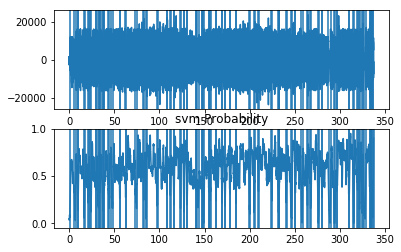

C:\Users\Videet\AppData\Roaming\Python\Python36\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


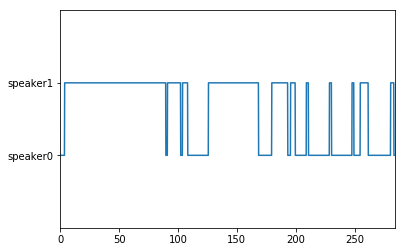

In [5]:
from hmmlearn import hmm
file_name = "Audio.wav"

[Fs, x] = aIO.readAudioFile(file_name)
segments = aS.silenceRemoval(x, Fs, 0.050, 0.025, smoothWindow = 1.0, weight = 0.3, plot = True)

audio = []

for i in range(len(segments)):
    start = int(segments[i][0]*Fs)
    end = int(segments[i][1]*Fs)    
    audio.extend(x[start:end])
    
write('arnab_silence.wav', Fs, np.array(audio))

F_mt, F_st, f_names_mt= aF.mtFeatureExtraction(audio, Fs, 2*Fs, 0.2*Fs, 0.050*Fs, 0.025*Fs) 

#pd.DataFrame(F_st).to_csv("arnab_st.csv")
speaker_labels = diarization("arnab_silence.wav", mt_size=2.0,mt_step=0.2,st_win=0.05,lda_dim=35,plot_res=True, n_speakers= 2)


In [6]:
len(speaker_labels)

1423

In [7]:
arousal = []
valance = []
result = []
for i in range(len(speaker_labels)-10):    
    write("arnab"+str(i)+".wav", Fs, np.array(audio[int(i*0.2*Fs):int((i+10)*0.2*Fs)]))
    result.append(aT.fileRegression("arnab"+str(i)+".wav", "svmSpeechEmotion", "svm"))
    arousal.append(result[-1][0][0])
    valance.append(result[-1][0][0])
    
#pd.DataFrame(valance).to_csv("arnab_valance.csv")
#pd.DataFrame(arousal).to_csv("arnab_arousal.csv")
#rs = pd.DataFrame(result)
#rs.to_csv("rajeevresult.csv")



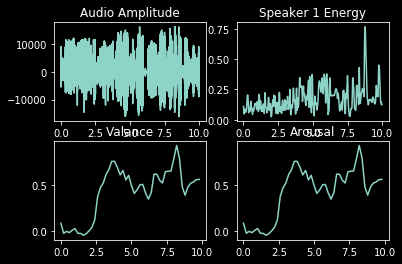

In [8]:
import pyaudio  
import wave  

#define stream chunk   
chunk = 1024  

#open a wav format music  
f = wave.open("arnab_silence.wav","rb")  
#instantiate PyAudio  
p = pyaudio.PyAudio()  
#open stream  
stream = p.open(format = p.get_format_from_width(f.getsampwidth()), channels = f.getnchannels(), rate = f.getframerate(), output = True)  


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
from matplotlib.pyplot import waitforbuttonpress as wt
from scipy import signal
from scipy.io import wavfile
from scipy.io.wavfile import write
import msvcrt

samples = audio

#Fs, samples = wavfile.read('arnab_silence.wav')
#X = pd.read_csv("arnab_silence_st.csv", header = None)
#X1 = pd.read_csv("arnab_arousal.csv", header = None)
#arousal = X1[1][1:]
#X1 = pd.read_csv("arnab_valance.csv", header = None)
#valance = X1[1][1:]
#speaker_labels = pd.read_csv("speaker_labels.csv")
#speaker_labels = speaker_labels['0']

x1= [j/float(Fs) for j in range(len(samples))]
x2= [j*0.025 for j in range(int(len(samples)/(Fs*0.025)))]
x3= [j*0.2 for j in range(int(len(samples)/(Fs*0.2)))]
     
time_sec = 10
style.use('dark_background')

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
#y = random.sample(range(10,100), 1000)
#y = [random.randint(10,100) for i in range(1000)]

#read data  
data = f.readframes(chunk)  


for i in range(0, len(samples), 44100):
    #play stream  

    stream.write(data)  
    data = f.readframes(chunk) 
    
    x1s = x1[i:i+int(time_sec*Fs)]
    y1s = samples[i:i+int(time_sec*Fs)]
    ax1.clear()
    ax1.set_title("Audio Amplitude")
    ax1.plot(x1s, y1s)
    
    
    x2s = x2[int(i/(Fs*0.005)):int(i/(Fs*0.025)+(time_sec/0.025))]
    y2s = F_st[0][int(i/(Fs*0.005)):int(i/(Fs*0.025)+(time_sec/0.025))]
    ax2.clear()
    if(np.mean(speaker_labels[int(i/(Fs*0.2)):int(i/(Fs*0.2)+(time_sec/0.2))])>0.5):
        ax2.set_title("Speaker 1 Energy")
    else:
        ax2.set_title("Speaker 2 Energy")
    ax2.plot(x2s, y2s)
    
    
    x3s = x3[int(i/(Fs*0.1)):int(i/(Fs*0.2)+(time_sec/0.2))]
    y3s = valance[int(i/(Fs*0.1)):int(i/(Fs*0.2)+(time_sec/0.2))]
    ax3.clear()
    ax3.set_title("Valance")
    ax3.plot(x3s, y3s)
    
    x4s = x3[int(i/(Fs*0.1)):int(i/(Fs*0.2)+(time_sec/0.2))]
    y4s = arousal[int(i/(Fs*0.1)):int(i/(Fs*0.2)+(time_sec/0.2))]
    ax4.clear()
    ax4.set_title("Arousal")
    ax4.plot(x4s, y4s)
    
    plt.show()
    plt.pause(0.000001)

#stop stream  
stream.stop_stream()  
stream.close()

#close PyAudio  
p.terminate()